In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import requests
import glob
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import os

In [3]:
file_path = "../data/processed/item_price_lag_filled.csv"
data = pd.read_csv(file_path)
data['priceDate'] = pd.to_datetime(data['priceDate'], errors='coerce')
# 2018년 이후 데이터터
data = data[data['priceDate'] >= '2018-01-01']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138942 entries, 1041 to 163865
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   priceDate       138942 non-null  datetime64[ns]
 1   item            138942 non-null  object        
 2   market          138942 non-null  object        
 3   minPrice        138942 non-null  float64       
 4   avgPrice        138942 non-null  float64       
 5   maxPrice        138942 non-null  float64       
 6   avgPrice_lag_1  138901 non-null  float64       
 7   avgPrice_lag_2  138860 non-null  float64       
 8   avgPrice_lag_3  138819 non-null  float64       
 9   avgPrice_lag_7  138659 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.7+ MB


In [4]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '우럭'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

if not file_list:
    raise FileNotFoundError("기상 데이터 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 각 파일을 개별적으로 처리 후 리스트에 저장
df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby(['지점', '날짜']).mean().reset_index()

# 지역별 데이터 분리
selected_locations = {'부안': 22186, '가거도': [22297, 22193], '통영': 22188}
df_buan = daily_avg[daily_avg['지점'] == selected_locations['부안']]
df_gageodo = daily_avg[daily_avg['지점'].isin(selected_locations['가거도'])].groupby('날짜').mean().reset_index()
df_tongyoung = daily_avg[daily_avg['지점'] == selected_locations['통영']]

def analyze_correlation(weather_df, price_df, max_lag=30):
    best_lag = 0
    best_corr = -1
    for lag in range(max_lag + 1):
        shifted_prices = price_df.copy()
        shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)
        merged = pd.merge(shifted_prices, weather_df, on='날짜', how='inner')
        if not merged.empty:
            scaler = StandardScaler()
            
            # 수치형 데이터만 선택
            numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
            weather_scaled = scaler.fit_transform(merged[numeric_cols])
            price_scaled = scaler.fit_transform(merged[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled[:, 0])
            if corr > best_corr:
                best_corr = corr
                best_lag = lag
    return best_lag, best_corr

### 이하 우럭

In [5]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '우럭'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 기상 데이터와 가격 데이터 병합
merged_data = pd.merge(rockfish_prices, daily_avg, on='날짜', how='inner')

# 유사도 분석 함수
def calculate_overall_correlation(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        if col != 'avgPrice':
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(data[[col]])
            price_scaled = scaler.fit_transform(data[['avgPrice']])
            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            correlations[col] = corr

    return correlations

# 전체 데이터 상관계수 계산
overall_correlations = calculate_overall_correlation(merged_data)

# 결과 출력
print("전체 지역과 우럭 가격의 상관계수:")
for key, value in overall_correlations.items():
    print(f"{key}: {value:.4f}")

전체 지역과 우럭 가격의 상관계수:
지점: -0.3785
풍속(m/s): 0.2295
풍향(deg): 0.2297
GUST풍속(m/s): 0.2741
현지기압(hPa): 0.3426
습도(%): -0.4572
기온(°C): -0.3452
수온(°C): -0.2187
최대파고(m): 0.2275
유의파고(m): 0.2294
평균파고(m): 0.2306
파주기(sec): 0.2638
파향(deg): 0.1734


### 가거도, 부안, 통영

In [6]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '우럭'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

# 각 파일을 개별적으로 처리 후 리스트에 저장
df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby(['지점', '날짜']).mean(numeric_only=True).reset_index()

# 지역별 데이터 분리 (부안, 가거도, 통영)
selected_locations = {'부안': 22186, '가거도': [22297, 22193], '통영': 22188}
df_buan = daily_avg[daily_avg['지점'] == selected_locations['부안']]
df_gageodo = daily_avg[daily_avg['지점'].isin(selected_locations['가거도'])].groupby('날짜').mean().reset_index()
df_tongyoung = daily_avg[daily_avg['지점'] == selected_locations['통영']]

# 모든 지역 데이터 통합
all_weather_data = pd.concat([df_buan, df_gageodo, df_tongyoung]).groupby('날짜').mean().reset_index()

# 유사도 분석 함수
def calculate_correlations(weather_df, price_df):
    merged = pd.merge(price_df, weather_df, on='날짜', how='inner')
    numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        scaler = StandardScaler()
        weather_scaled = scaler.fit_transform(merged[[col]])
        price_scaled = scaler.fit_transform(merged[['avgPrice']])
        corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
        correlations[col] = corr

    return correlations

# 개별 항목과의 상관계수 계산
individual_correlations = calculate_correlations(all_weather_data, rockfish_prices)
individual_correlations

# # # 유의미한 항목 선별 (절대 상관계수 0.3 이상)
# significant_columns = [k for k, v in individual_correlations.items() if abs(v) >= 0.3]

# # 선택된 유의미한 항목만 추출
# if significant_columns:
#     significant_data = all_weather_data[['날짜'] + significant_columns]
#     combined_correlation = calculate_correlations(significant_data, rockfish_prices)
# else:
#     combined_correlation = {}

# # 결과 출력
# individual_correlations, combined_correlation

{'avgPrice': np.float64(1.0),
 '지점': np.float64(-0.2909706006666098),
 '풍속(m/s)': np.float64(0.2746287583498614),
 '풍향(deg)': np.float64(0.2029877026244553),
 'GUST풍속(m/s)': np.float64(0.2872707617250629),
 '현지기압(hPa)': np.float64(0.4037666148048912),
 '습도(%)': np.float64(-0.4341703792340106),
 '기온(°C)': np.float64(-0.3619870290917399),
 '수온(°C)': np.float64(-0.25429761048978494),
 '최대파고(m)': np.float64(0.13499602336488062),
 '유의파고(m)': np.float64(0.14364934288625494),
 '평균파고(m)': np.float64(0.1432662483130067),
 '파주기(sec)': np.float64(0.1851249401592211),
 '파향(deg)': np.float64(0.23659185046220035)}

# 이하 참돔

In [7]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '참돔'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 기상 데이터와 가격 데이터 병합
merged_data = pd.merge(rockfish_prices, daily_avg, on='날짜', how='inner')

# 유사도 분석 함수
def calculate_overall_correlation(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        if col != 'avgPrice':
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(data[[col]])
            price_scaled = scaler.fit_transform(data[['avgPrice']])
            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            correlations[col] = corr

    return correlations

# 전체 데이터 상관계수 계산
overall_correlations = calculate_overall_correlation(merged_data)

# 결과 출력
print("전체 지역과 참돔 가격의 상관계수:")
for key, value in overall_correlations.items():
    print(f"{key}: {value:.4f}")

전체 지역과 참돔 가격의 상관계수:
지점: 0.7174
풍속(m/s): 0.0461
풍향(deg): 0.0222
GUST풍속(m/s): 0.0614
현지기압(hPa): 0.0759
습도(%): 0.0151
기온(°C): 0.0045
수온(°C): 0.0912
최대파고(m): 0.0114
유의파고(m): 0.0366
평균파고(m): 0.0118
파주기(sec): -0.2234
파향(deg): -0.0484


In [8]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '참돔'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

# 각 파일을 개별적으로 처리 후 리스트에 저장
df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby(['지점', '날짜']).mean(numeric_only=True).reset_index()

# 지역별 데이터 분리 (부안, 가거도, 통영)
selected_locations = {'가거도': [22297, 22193], '통영': 22188}
df_gageodo = daily_avg[daily_avg['지점'].isin(selected_locations['가거도'])].groupby('날짜').mean().reset_index()
df_tongyoung = daily_avg[daily_avg['지점'] == selected_locations['통영']]

# 모든 지역 데이터 통합
all_weather_data = pd.concat([df_buan, df_gageodo, df_tongyoung]).groupby('날짜').mean().reset_index()

# 유사도 분석 함수
def calculate_correlations(weather_df, price_df):
    merged = pd.merge(price_df, weather_df, on='날짜', how='inner')
    numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        scaler = StandardScaler()
        weather_scaled = scaler.fit_transform(merged[[col]])
        price_scaled = scaler.fit_transform(merged[['avgPrice']])
        corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
        correlations[col] = corr

    return correlations

# 개별 항목과의 상관계수 계산
individual_correlations = calculate_correlations(all_weather_data, rockfish_prices)
individual_correlations

{'avgPrice': np.float64(1.0),
 '지점': np.float64(0.38527354533824365),
 '풍속(m/s)': np.float64(0.0589457544239286),
 '풍향(deg)': np.float64(-0.008655320766031736),
 'GUST풍속(m/s)': np.float64(0.09594358254995757),
 '현지기압(hPa)': np.float64(0.05675589788194707),
 '습도(%)': np.float64(0.012397045829841281),
 '기온(°C)': np.float64(0.04573803756912134),
 '수온(°C)': np.float64(0.11376503420992212),
 '최대파고(m)': np.float64(0.05878279355867318),
 '유의파고(m)': np.float64(0.08469307854039856),
 '평균파고(m)': np.float64(0.07211038025466467),
 '파주기(sec)': np.float64(-0.27869234991069236),
 '파향(deg)': np.float64(0.027916905034034233)}

# 이하 방어

In [9]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '방어'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 기상 데이터와 가격 데이터 병합
merged_data = pd.merge(rockfish_prices, daily_avg, on='날짜', how='inner')

# 유사도 분석 함수
def calculate_overall_correlation(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        if col != 'avgPrice':
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(data[[col]])
            price_scaled = scaler.fit_transform(data[['avgPrice']])
            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            correlations[col] = corr

    return correlations

# 전체 데이터 상관계수 계산
overall_correlations = calculate_overall_correlation(merged_data)

# 결과 출력
print("전체 지역과 방어 가격의 상관계수:")
for key, value in overall_correlations.items():
    print(f"{key}: {value:.4f}")

전체 지역과 방어 가격의 상관계수:
지점: 0.6250
풍속(m/s): 0.0516
풍향(deg): 0.0705
GUST풍속(m/s): 0.0643
현지기압(hPa): 0.0428
습도(%): 0.0240
기온(°C): -0.0695
수온(°C): -0.0147
최대파고(m): 0.0418
유의파고(m): 0.0609
평균파고(m): 0.0395
파주기(sec): -0.2475
파향(deg): -0.0053


In [10]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '방어'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

# 각 파일을 개별적으로 처리 후 리스트에 저장
df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby(['지점', '날짜']).mean(numeric_only=True).reset_index()

# 지역별 데이터 분리 (부안, 가거도, 통영)
selected_locations = {'가거도': [22297, 22193], '통영': 22188}
df_gageodo = daily_avg[daily_avg['지점'].isin(selected_locations['가거도'])].groupby('날짜').mean().reset_index()
df_tongyoung = daily_avg[daily_avg['지점'] == selected_locations['통영']]

# 모든 지역 데이터 통합
all_weather_data = pd.concat([df_buan, df_gageodo, df_tongyoung]).groupby('날짜').mean().reset_index()

# 유사도 분석 함수
def calculate_correlations(weather_df, price_df):
    merged = pd.merge(price_df, weather_df, on='날짜', how='inner')
    numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        scaler = StandardScaler()
        weather_scaled = scaler.fit_transform(merged[[col]])
        price_scaled = scaler.fit_transform(merged[['avgPrice']])
        corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
        correlations[col] = corr

    return correlations

# 개별 항목과의 상관계수 계산
individual_correlations = calculate_correlations(all_weather_data, rockfish_prices)
individual_correlations

{'avgPrice': np.float64(0.9999999999999998),
 '지점': np.float64(0.1196726431971852),
 '풍속(m/s)': np.float64(0.054406924371199566),
 '풍향(deg)': np.float64(0.07521079533801875),
 'GUST풍속(m/s)': np.float64(0.08824183040868319),
 '현지기압(hPa)': np.float64(0.031169153502364537),
 '습도(%)': np.float64(0.02541044103838705),
 '기온(°C)': np.float64(-0.010418222121085813),
 '수온(°C)': np.float64(0.030373423953473443),
 '최대파고(m)': np.float64(0.03640739668664986),
 '유의파고(m)': np.float64(0.05425884643807624),
 '평균파고(m)': np.float64(0.043455911982901024),
 '파주기(sec)': np.float64(-0.23389196543514995),
 '파향(deg)': np.float64(0.07463536491862163)}

# 대게

In [11]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '대게'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 기상 데이터와 가격 데이터 병합
merged_data = pd.merge(rockfish_prices, daily_avg, on='날짜', how='inner')

# 유사도 분석 함수
def calculate_overall_correlation(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        if col != 'avgPrice':
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(data[[col]])
            price_scaled = scaler.fit_transform(data[['avgPrice']])
            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            correlations[col] = corr

    return correlations

# 전체 데이터 상관계수 계산
overall_correlations = calculate_overall_correlation(merged_data)

# 결과 출력
print("전체 지역과 대게 가격의 상관계수:")
for key, value in overall_correlations.items():
    print(f"{key}: {value:.4f}")

전체 지역과 대게 가격의 상관계수:
지점: 0.3759
풍속(m/s): 0.2975
풍향(deg): 0.2053
GUST풍속(m/s): 0.3443
현지기압(hPa): 0.5041
습도(%): -0.4940
기온(°C): -0.4931
수온(°C): -0.3466
최대파고(m): 0.2829
유의파고(m): 0.2914
평균파고(m): 0.2795
파주기(sec): 0.1540
파향(deg): 0.0635


In [12]:
# 대게 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '대게'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

# 각 파일을 개별적으로 처리 후 리스트에 저장
df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby(['지점', '날짜']).mean(numeric_only=True).reset_index()

# 지역별 데이터 분리 (부안, 가거도, 통영)
selected_locations = {'부안': [22186]}
df_gageodo = daily_avg[daily_avg['지점'].isin(selected_locations['부안'])].groupby('날짜').mean().reset_index()

# 모든 지역 데이터 통합
all_weather_data = pd.concat([df_buan, df_gageodo, df_tongyoung]).groupby('날짜').mean().reset_index()

# 유사도 분석 함수
def calculate_correlations(weather_df, price_df):
    merged = pd.merge(price_df, weather_df, on='날짜', how='inner')
    numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        scaler = StandardScaler()
        weather_scaled = scaler.fit_transform(merged[[col]])
        price_scaled = scaler.fit_transform(merged[['avgPrice']])
        corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
        correlations[col] = corr

    return correlations

# 개별 항목과의 상관계수 계산
individual_correlations = calculate_correlations(all_weather_data, rockfish_prices)
individual_correlations

{'avgPrice': np.float64(0.9999999999999998),
 '지점': np.float64(-0.062196129817206985),
 '풍속(m/s)': np.float64(0.30054166259938275),
 '풍향(deg)': np.float64(0.10262992590325193),
 'GUST풍속(m/s)': np.float64(0.3285639726206786),
 '현지기압(hPa)': np.float64(0.521052311015256),
 '습도(%)': np.float64(nan),
 '기온(°C)': np.float64(-0.5116191346520339),
 '수온(°C)': np.float64(-0.3867970906283041),
 '최대파고(m)': np.float64(0.25894650729983065),
 '유의파고(m)': np.float64(0.2670293735014785),
 '평균파고(m)': np.float64(0.2646177465494437),
 '파주기(sec)': np.float64(0.018008969607395835),
 '파향(deg)': np.float64(0.20783479976598376)}

#   이하 광어

In [13]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '광어'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 기상 데이터와 가격 데이터 병합
merged_data = pd.merge(rockfish_prices, daily_avg, on='날짜', how='inner')

# 유사도 분석 함수
def calculate_overall_correlation(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        if col != 'avgPrice':
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(data[[col]])
            price_scaled = scaler.fit_transform(data[['avgPrice']])
            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            correlations[col] = corr

    return correlations

# 전체 데이터 상관계수 계산
overall_correlations = calculate_overall_correlation(merged_data)

# 결과 출력
print("전체 지역과 광어 가격의 상관계수:")
for key, value in overall_correlations.items():
    print(f"{key}: {value:.4f}")

전체 지역과 광어 가격의 상관계수:
지점: 0.7861
풍속(m/s): 0.0574
풍향(deg): 0.0240
GUST풍속(m/s): 0.0753
현지기압(hPa): 0.0801
습도(%): 0.0002
기온(°C): -0.0179
수온(°C): 0.0558
최대파고(m): 0.0213
유의파고(m): 0.0469
평균파고(m): 0.0241
파주기(sec): -0.1448
파향(deg): -0.0109


In [14]:
# 우럭 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data[price_data['priceDate'] >= '2018-01-01']
price_data['날짜'] = price_data['priceDate'].dt.date
rockfish_prices = price_data[price_data['item'] == '광어'].groupby('날짜')['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

# 각 파일을 개별적으로 처리 후 리스트에 저장
df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby(['지점', '날짜']).mean(numeric_only=True).reset_index()

# 지역별 데이터 분리 (부안, 가거도, 통영)
selected_locations = {'가거도': [22297, 22193], '마라도': 22188, '통영': 22188}
df_gageodo = daily_avg[daily_avg['지점'].isin(selected_locations['가거도'])].groupby('날짜').mean().reset_index()
df_tongyoung = daily_avg[daily_avg['지점'] == selected_locations['통영']]
df_marado = daily_avg[daily_avg['지점'] == selected_locations['마라도']]

# 모든 지역 데이터 통합
all_weather_data = pd.concat([df_buan, df_gageodo, df_tongyoung]).groupby('날짜').mean().reset_index()

# 유사도 분석 함수
def calculate_correlations(weather_df, price_df):
    merged = pd.merge(price_df, weather_df, on='날짜', how='inner')
    numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
    correlations = {}

    for col in numeric_cols:
        scaler = StandardScaler()
        weather_scaled = scaler.fit_transform(merged[[col]])
        price_scaled = scaler.fit_transform(merged[['avgPrice']])
        corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
        correlations[col] = corr

    return correlations

# 개별 항목과의 상관계수 계산
individual_correlations = calculate_correlations(all_weather_data, rockfish_prices)
individual_correlations

{'avgPrice': np.float64(1.0),
 '지점': np.float64(0.5372792955026775),
 '풍속(m/s)': np.float64(0.06442489586061431),
 '풍향(deg)': np.float64(-0.006991582286604785),
 'GUST풍속(m/s)': np.float64(0.10348563396205601),
 '현지기압(hPa)': np.float64(0.07840365716056726),
 '습도(%)': np.float64(-0.013587590042486906),
 '기온(°C)': np.float64(0.005764803272428218),
 '수온(°C)': np.float64(0.07661706420517839),
 '최대파고(m)': np.float64(0.07568211235681843),
 '유의파고(m)': np.float64(0.10095978866152949),
 '평균파고(m)': np.float64(0.09050118317151007),
 '파주기(sec)': np.float64(-0.19212964624737272),
 '파향(deg)': np.float64(0.04337381929813404)}

이하 시계열 분석

In [15]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv( '../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data = price_data.copy()
price_data['날짜'] = price_data['priceDate'].dt.date

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 시차 적용 및 상관계수 분석 함수
def analyze_lagged_correlation_with_confidence(weather_df, price_df, max_lag=180, alpha=0.05, bootstrap_samples=20):
    results = {}
    for item in price_df['item'].unique():
        item_prices = price_df[price_df['item'] == item].groupby('날짜')['avgPrice'].mean().reset_index()
        best_lag = 0
        best_corr = -1
        best_p_value = 1
        conf_intervals = []

        for lag in range(max_lag + 1):
            shifted_prices = item_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)
            merged = pd.merge(shifted_prices, weather_df, on='날짜', how='inner')

            if not merged.empty:
                numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
                for col in numeric_cols:
                    if col != 'avgPrice':
                        scaler = StandardScaler()
                        weather_scaled = scaler.fit_transform(merged[[col]])
                        price_scaled = scaler.fit_transform(merged[['avgPrice']])
                        
                        corr, p_value = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

                        # 부트스트래핑을 통해 신뢰구간 계산
                        bootstrapped_corrs = []
                        for _ in range(bootstrap_samples):
                            sample_indices = np.random.choice(len(merged), len(merged), replace=True)
                            sampled_weather = weather_scaled[sample_indices]
                            sampled_price = price_scaled[sample_indices]
                            boot_corr, _ = pearsonr(sampled_price.flatten(), sampled_weather.flatten())
                            bootstrapped_corrs.append(boot_corr)
                        
                        conf_low, conf_high = np.percentile(bootstrapped_corrs, [100 * alpha / 2, 100 * (1 - alpha / 2)])

                        if corr > best_corr and p_value < alpha:
                            best_corr = corr
                            best_lag = lag
                            best_p_value = p_value
                            conf_intervals = (conf_low, conf_high)

        results[item] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            'p-value': best_p_value,
            '신뢰구간': conf_intervals
        }
    return results

# 분석 수행
results_with_confidence = analyze_lagged_correlation_with_confidence(daily_avg, price_data)

# 결과 출력
print("어종별 최적 지연 기간 및 신뢰도 분석:")
for item, result in results_with_confidence.items():
    print(f"{item} - 최적 지연 기간: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, "
          f"p-value: {result['p-value']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}")

KeyboardInterrupt: 

C:\Users\user\AppData\Local\Temp\ipykernel_30016\4019823210.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


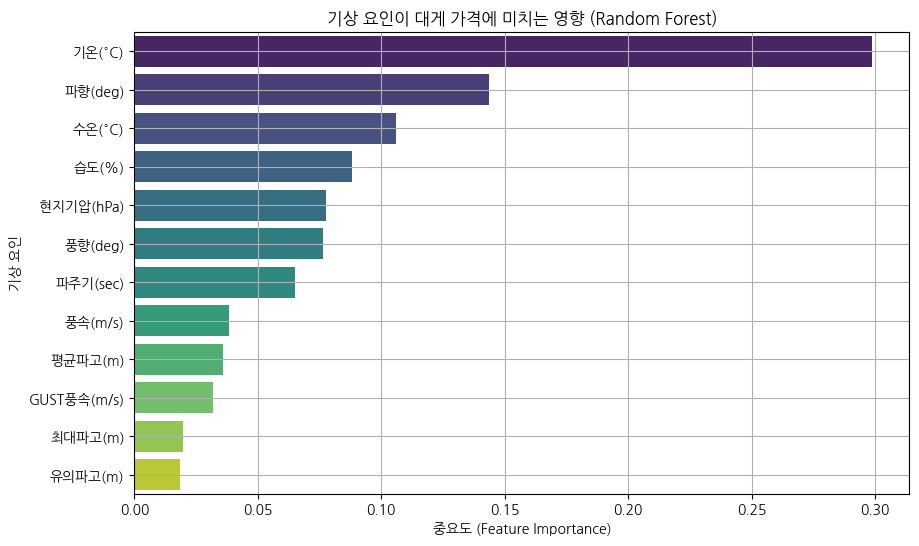

기상 데이터가 수산물 가격에 미치는 영향 (중요도 순):
        Feature  Importance
5        기온(°C)    0.298986
11      파향(deg)    0.143802
6        수온(°C)    0.105998
4         습도(%)    0.088239
3     현지기압(hPa)    0.077465
1       풍향(deg)    0.076376
10     파주기(sec)    0.064882
0       풍속(m/s)    0.038332
9       평균파고(m)    0.035902
2   GUST풍속(m/s)    0.031645
7       최대파고(m)    0.019775
8       유의파고(m)    0.018598


In [25]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)

# 일별 평균 기상 데이터 계산
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 수산물 가격과 기상 데이터를 날짜 기준으로 병합
merged_df = pd.merge(price_data, daily_avg, on='날짜', how='inner')

# 특정 어종 선택 (예: 광어)
fish_type = '대게'
merged_fish = merged_df[merged_df['item'] == fish_type].drop(columns=['item', '날짜'])

# 독립 변수(X) 및 종속 변수(y) 설정
X = merged_fish.drop(columns=['avgPrice'])  # 기상 요인들
y = merged_fish['avgPrice']  # 수산물 평균 가격

# 데이터 스케일링 (정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)

# 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestRegressor(n_estimators=100, random_state=12)
rf_model.fit(X_train, y_train)

# 피처 중요도 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도 시각화
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title(f'기상 요인이 {fish_type} 가격에 미치는 영향 (Random Forest)')
plt.xlabel('중요도 (Feature Importance)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()

# 중요한 기상 요인 출력
print("기상 데이터가 수산물 가격에 미치는 영향 (중요도 순):")
print(importance_df)

C:\Users\user\AppData\Local\Temp\ipykernel_30016\1730636178.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


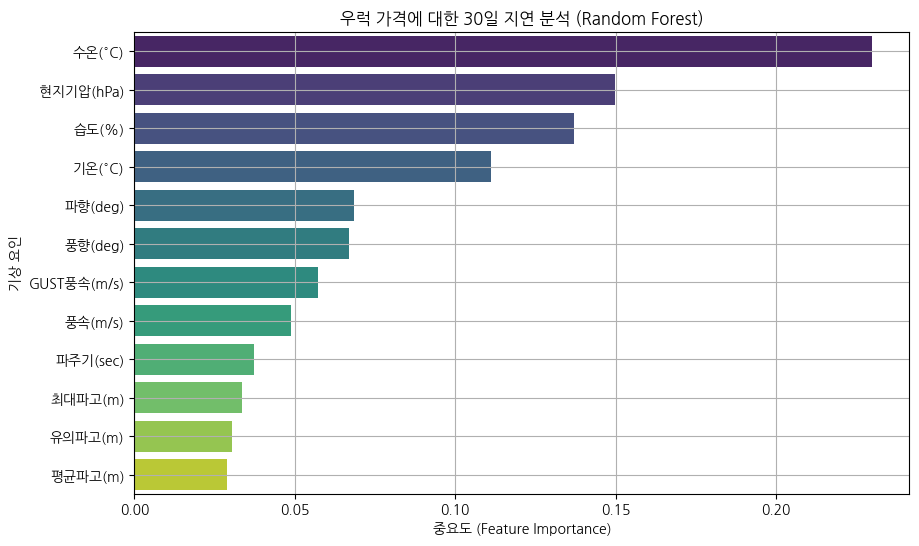


우럭 가격에 대한 30일 지연 분석 결과:
        Feature  Importance
6        수온(°C)    0.230115
3     현지기압(hPa)    0.149727
4         습도(%)    0.137096
5        기온(°C)    0.111292
11      파향(deg)    0.068526
1       풍향(deg)    0.066837
2   GUST풍속(m/s)    0.057315
0       풍속(m/s)    0.048905
10     파주기(sec)    0.037431
7       최대파고(m)    0.033445
8       유의파고(m)    0.030351
9       평균파고(m)    0.028960


C:\Users\user\AppData\Local\Temp\ipykernel_30016\1730636178.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


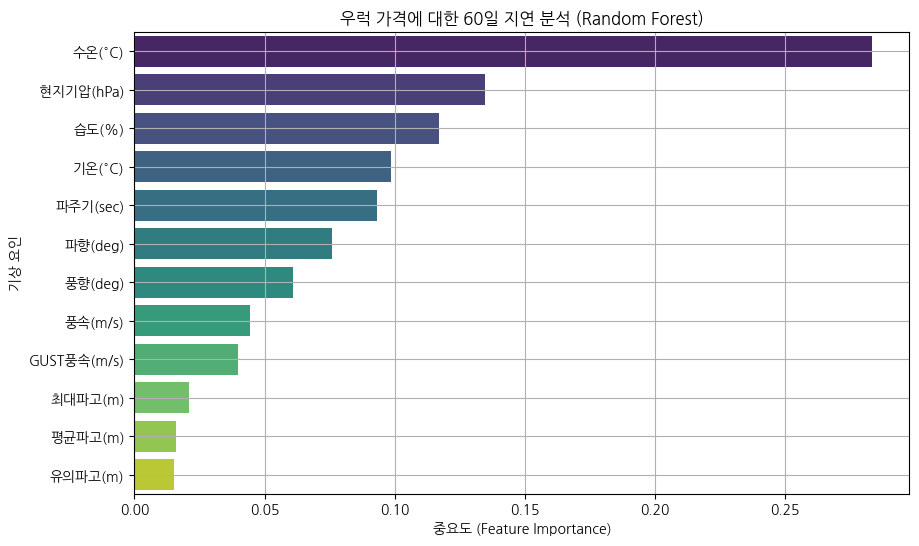


우럭 가격에 대한 60일 지연 분석 결과:
        Feature  Importance
6        수온(°C)    0.283527
3     현지기압(hPa)    0.134767
4         습도(%)    0.117103
5        기온(°C)    0.098602
10     파주기(sec)    0.093060
11      파향(deg)    0.075817
1       풍향(deg)    0.060987
0       풍속(m/s)    0.044253
2   GUST풍속(m/s)    0.039846
7       최대파고(m)    0.020959
9       평균파고(m)    0.015824
8       유의파고(m)    0.015257


C:\Users\user\AppData\Local\Temp\ipykernel_30016\1730636178.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


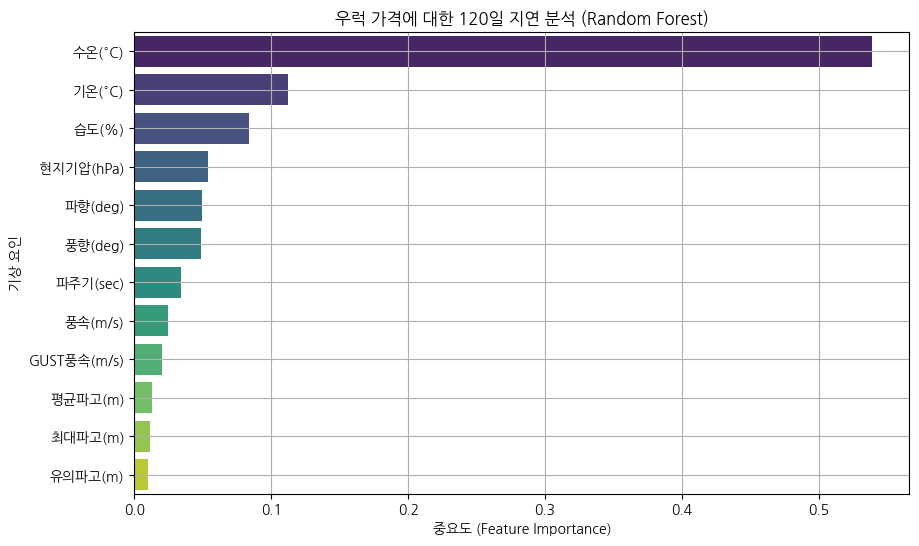


우럭 가격에 대한 120일 지연 분석 결과:
        Feature  Importance
6        수온(°C)    0.539274
5        기온(°C)    0.111904
4         습도(%)    0.083710
3     현지기압(hPa)    0.053752
11      파향(deg)    0.049167
1       풍향(deg)    0.048328
10     파주기(sec)    0.034239
0       풍속(m/s)    0.024747
2   GUST풍속(m/s)    0.020040
9       평균파고(m)    0.013161
7       최대파고(m)    0.011666
8       유의파고(m)    0.010012


C:\Users\user\AppData\Local\Temp\ipykernel_30016\1730636178.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


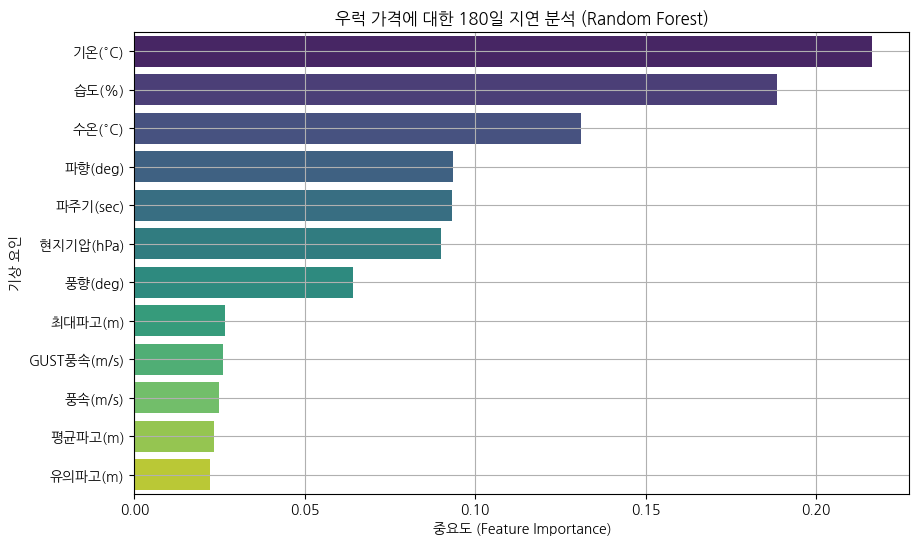


우럭 가격에 대한 180일 지연 분석 결과:
        Feature  Importance
5        기온(°C)    0.216517
4         습도(%)    0.188625
6        수온(°C)    0.130955
11      파향(deg)    0.093582
10     파주기(sec)    0.093189
3     현지기압(hPa)    0.089883
1       풍향(deg)    0.064139
7       최대파고(m)    0.026651
2   GUST풍속(m/s)    0.025896
0       풍속(m/s)    0.024887
9       평균파고(m)    0.023364
8       유의파고(m)    0.022312


C:\Users\user\AppData\Local\Temp\ipykernel_30016\1730636178.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


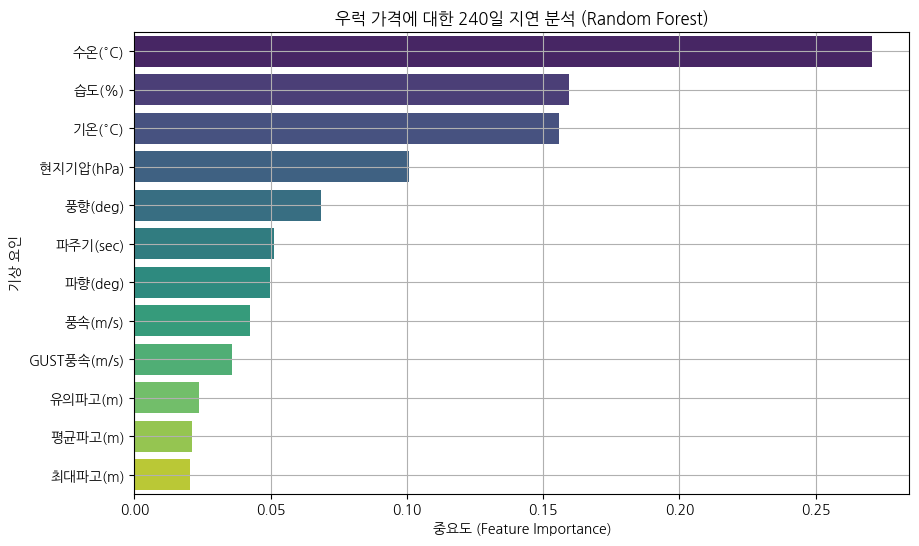


우럭 가격에 대한 240일 지연 분석 결과:
        Feature  Importance
6        수온(°C)    0.270824
4         습도(%)    0.159385
5        기온(°C)    0.155835
3     현지기압(hPa)    0.100734
1       풍향(deg)    0.068632
10     파주기(sec)    0.051181
11      파향(deg)    0.049781
0       풍속(m/s)    0.042459
2   GUST풍속(m/s)    0.035960
8       유의파고(m)    0.023883
9       평균파고(m)    0.020954
7       최대파고(m)    0.020371


C:\Users\user\AppData\Local\Temp\ipykernel_30016\1730636178.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


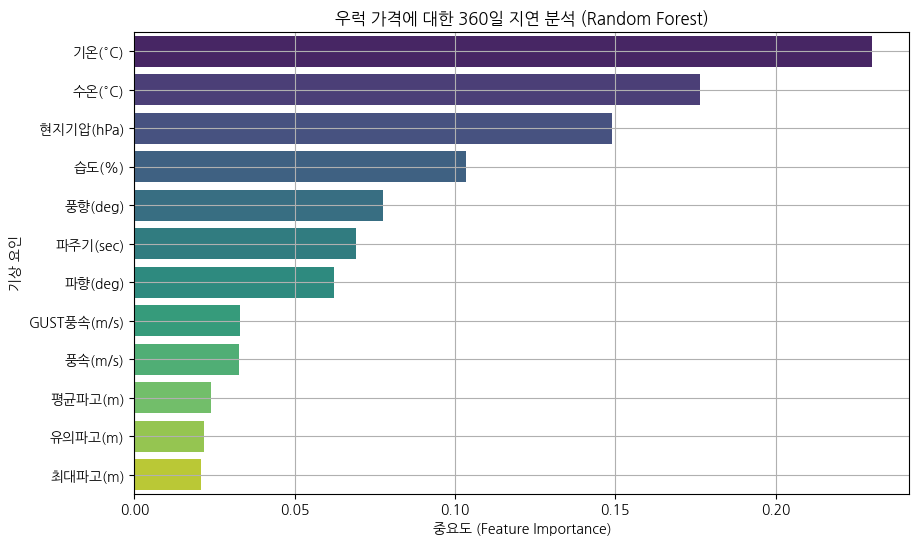


우럭 가격에 대한 360일 지연 분석 결과:
        Feature  Importance
5        기온(°C)    0.230247
6        수온(°C)    0.176541
3     현지기압(hPa)    0.149100
4         습도(%)    0.103557
1       풍향(deg)    0.077417
10     파주기(sec)    0.069215
11      파향(deg)    0.062369
2   GUST풍속(m/s)    0.032788
0       풍속(m/s)    0.032565
9       평균파고(m)    0.023881
8       유의파고(m)    0.021632
7       최대파고(m)    0.020689


In [27]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 특정 어종 선택 (예: 우럭)
fish_type = '우럭'
fish_prices = price_data[price_data['item'] == fish_type][['날짜', 'avgPrice']]

# 함수: 시차 적용 및 분석
def analyze_with_lag(fish_prices, weather_data, lag_days, fish_type):
    # 가격 데이터 시차 적용
    shifted_prices = fish_prices.copy()
    shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag_days)
    
    # 데이터 병합 (날짜 기준)
    merged_df = pd.merge(shifted_prices, weather_data, on='날짜', how='inner')

    # 독립 변수(X) 및 종속 변수(y) 설정
    X = merged_df.drop(columns=['avgPrice', '날짜'])
    y = merged_df['avgPrice']

    # 데이터 스케일링 (정규화)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 훈련 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 랜덤 포레스트 모델 생성 및 훈련
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 피처 중요도 추출
    feature_importances = rf_model.feature_importances_
    feature_names = X.columns

    # 중요도 결과 정리
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'{fish_type} 가격에 대한 {lag_days}일 지연 분석 (Random Forest)')
    plt.xlabel('중요도 (Feature Importance)')
    plt.ylabel('기상 요인')
    plt.grid()
    plt.show()

    # 출력
    print(f"\n{fish_type} 가격에 대한 {lag_days}일 지연 분석 결과:")
    print(importance_df)
    return importance_df

# 30일, 60일, 120일 지연 분석 실행
importance_30d = analyze_with_lag(fish_prices, daily_avg, 30, fish_type)
importance_60d = analyze_with_lag(fish_prices, daily_avg, 60, fish_type)
importance_120d = analyze_with_lag(fish_prices, daily_avg, 120, fish_type)
importance_120d = analyze_with_lag(fish_prices, daily_avg, 180, fish_type)
importance_120d = analyze_with_lag(fish_prices, daily_avg, 240, fish_type)
importance_120d = analyze_with_lag(fish_prices, daily_avg, 360, fish_type)

C:\Users\user\AppData\Local\Temp\ipykernel_30016\2251092628.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


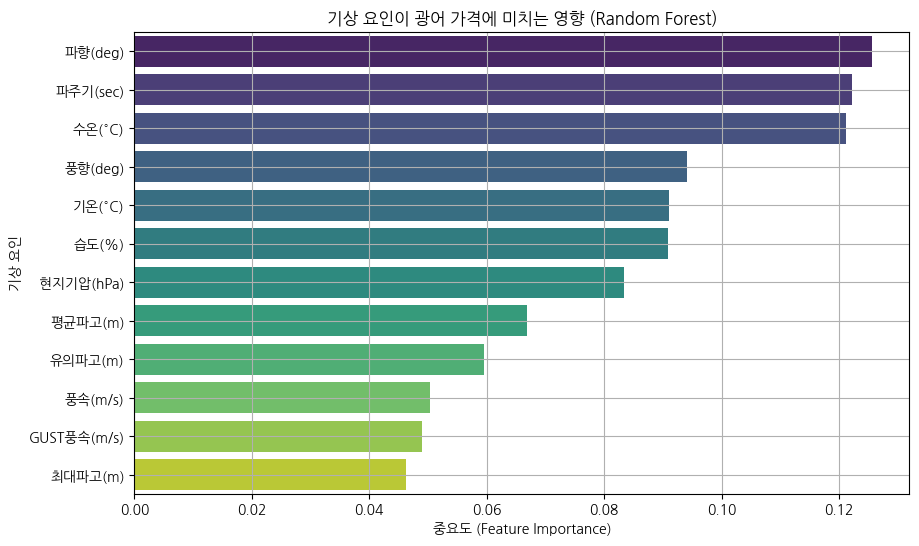

기상 데이터가 수산물 가격에 미치는 영향 (중요도 순):
        Feature  Importance
11      파향(deg)    0.125663
10     파주기(sec)    0.122116
6        수온(°C)    0.121069
1       풍향(deg)    0.094056
5        기온(°C)    0.091061
4         습도(%)    0.090911
3     현지기압(hPa)    0.083316
9       평균파고(m)    0.066817
8       유의파고(m)    0.059441
0       풍속(m/s)    0.050373
2   GUST풍속(m/s)    0.048917
7       최대파고(m)    0.046261


In [21]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)

# 일별 평균 기상 데이터 계산
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 수산물 가격과 기상 데이터를 날짜 기준으로 병합
merged_df = pd.merge(price_data, daily_avg, on='날짜', how='inner')

# 특정 어종 선택 (예: 광어)
fish_type = '광어'
merged_fish = merged_df[merged_df['item'] == fish_type].drop(columns=['item', '날짜'])

# 독립 변수(X) 및 종속 변수(y) 설정
X = merged_fish.drop(columns=['avgPrice'])  # 기상 요인들
y = merged_fish['avgPrice']  # 수산물 평균 가격

# 데이터 스케일링 (정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 피처 중요도 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도 시각화
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title(f'기상 요인이 {fish_type} 가격에 미치는 영향 (Random Forest)')
plt.xlabel('중요도 (Feature Importance)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()

# 중요한 기상 요인 출력
print("기상 데이터가 수산물 가격에 미치는 영향 (중요도 순):")
print(importance_df)

# 이하 수산물 별 피처 신뢰도 포함


각 기상 요인의 최적 지연 기간 및 신뢰구간:
풍속(m/s): 302일, 상관계수: 0.0936, 신뢰구간: 0.0604 ~ 0.1337
풍향(deg): 341일, 상관계수: 0.0366, 신뢰구간: 0.0031 ~ 0.0587
GUST풍속(m/s): 304일, 상관계수: 0.0873, 신뢰구간: 0.0654 ~ 0.1192
현지기압(hPa): 323일, 상관계수: 0.1107, 신뢰구간: 0.0774 ~ 0.1368
습도(%): 148일, 상관계수: 0.1410, 신뢰구간: 0.1062 ~ 0.1741
기온(°C): 96일, 상관계수: 0.1507, 신뢰구간: 0.1191 ~ 0.1770
수온(°C): 83일, 상관계수: 0.1852, 신뢰구간: 0.1618 ~ 0.2168
최대파고(m): 302일, 상관계수: 0.0599, 신뢰구간: 0.0343 ~ 0.0937
유의파고(m): 302일, 상관계수: 0.0782, 신뢰구간: 0.0471 ~ 0.1082
평균파고(m): 302일, 상관계수: 0.1024, 신뢰구간: 0.0747 ~ 0.1331
파주기(sec): 358일, 상관계수: -0.0368, 신뢰구간: -0.0661 ~ -0.0061
파향(deg): 173일, 상관계수: -0.1200, 신뢰구간: -0.1572 ~ -0.0835


C:\Users\user\AppData\Local\Temp\ipykernel_30016\3017907355.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


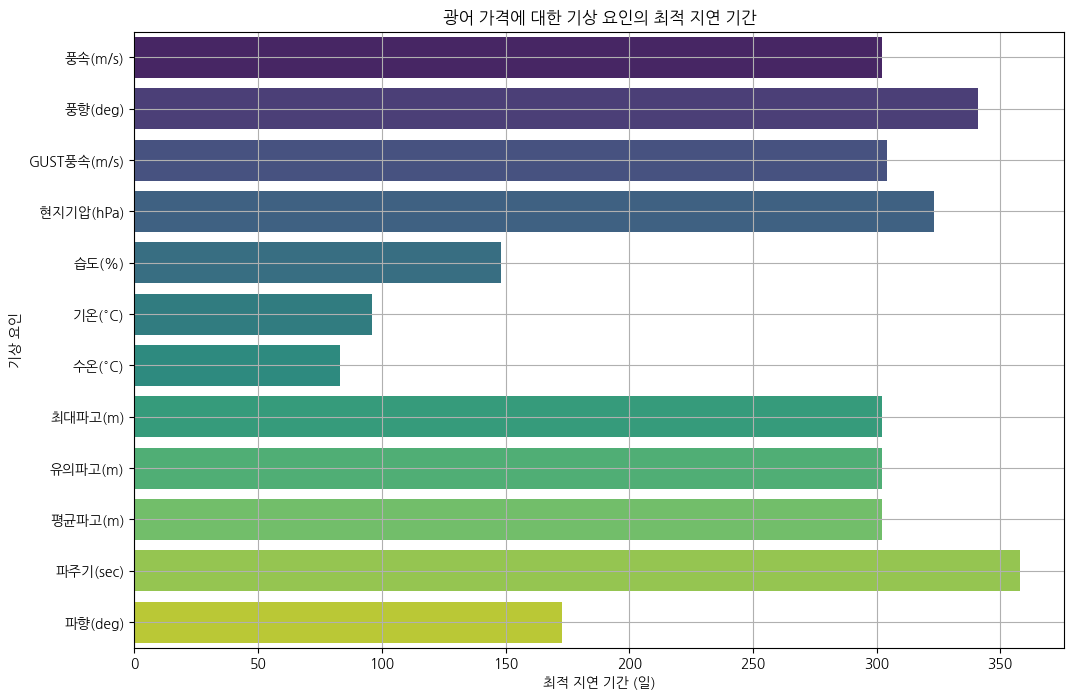

In [35]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 특정 어종 선택 (예: 우럭)
fish_type = '광어'
fish_prices = price_data[price_data['item'] == fish_type][['날짜', 'avgPrice']]

# 시차 적용 및 신뢰도 분석 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=360, bootstrap_samples=100):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            if merged_df.empty:
                continue

            # 상관관계 분석
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_prices = fish_prices.iloc[sampled_indices]
            shifted_sample = sampled_prices.copy()
            shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

# 분석 수행 (1일부터 360일까지 모든 기간 탐색 및 신뢰도 계산)
feature_columns = daily_avg.columns.drop('날짜')
optimal_lags_with_confidence = find_optimal_lags_with_confidence(fish_prices, daily_avg, feature_columns)

# 최적 지연 기간 결과 출력
print("\n각 기상 요인의 최적 지연 기간 및 신뢰구간:")
for feature, result in optimal_lags_with_confidence.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}")

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
            y=list(optimal_lags_with_confidence.keys()),
            palette='viridis')
plt.title(f'{fish_type} 가격에 대한 기상 요인의 최적 지연 기간')
plt.xlabel('최적 지연 기간 (일)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()


각 기상 요인의 최적 지연 기간 및 신뢰구간:
풍속(m/s): 360일, 상관계수: 0.2734, 신뢰구간: 0.2444 ~ 0.3029
풍향(deg): 357일, 상관계수: 0.2030, 신뢰구간: 0.1759 ~ 0.2342
GUST풍속(m/s): 360일, 상관계수: 0.2985, 신뢰구간: 0.2589 ~ 0.3307
현지기압(hPa): 347일, 상관계수: 0.4670, 신뢰구간: 0.4442 ~ 0.4916
습도(%): 190일, 상관계수: 0.4271, 신뢰구간: 0.4041 ~ 0.4478
기온(°C): 155일, 상관계수: 0.5674, 신뢰구간: 0.5446 ~ 0.5847
수온(°C): 139일, 상관계수: 0.5865, 신뢰구간: 0.5636 ~ 0.6028
최대파고(m): 359일, 상관계수: 0.2337, 신뢰구간: 0.1953 ~ 0.2652
유의파고(m): 359일, 상관계수: 0.2379, 신뢰구간: 0.2062 ~ 0.2745
평균파고(m): 359일, 상관계수: 0.2791, 신뢰구간: 0.2458 ~ 0.3126
파주기(sec): 358일, 상관계수: 0.0835, 신뢰구간: 0.0565 ~ 0.1168
파향(deg): 287일, 상관계수: -0.0946, 신뢰구간: -0.1303 ~ -0.0683


C:\Users\user\AppData\Local\Temp\ipykernel_30016\522551049.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


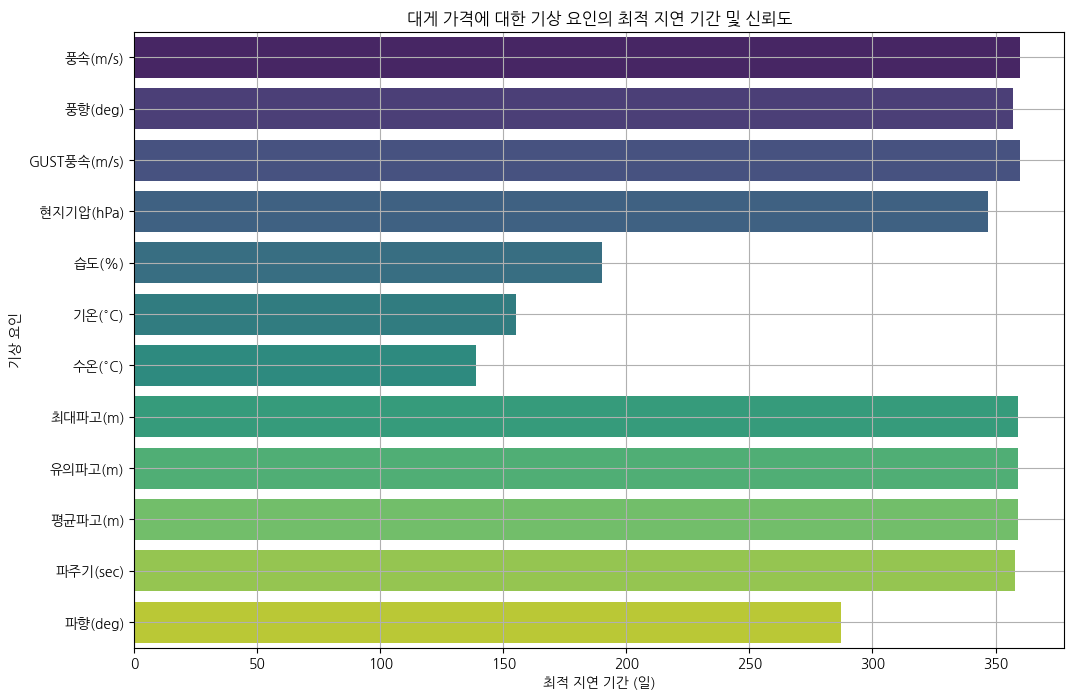

In [36]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 특정 어종 선택 (예: 우럭)
fish_type = '대게'
fish_prices = price_data[price_data['item'] == fish_type][['날짜', 'avgPrice']]

# 시차 적용 및 신뢰도 분석 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=360, bootstrap_samples=100):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            if merged_df.empty:
                continue

            # 상관관계 분석
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_prices = fish_prices.iloc[sampled_indices]
            shifted_sample = sampled_prices.copy()
            shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

# 분석 수행 (1일부터 360일까지 모든 기간 탐색 및 신뢰도 계산)
feature_columns = daily_avg.columns.drop('날짜')
optimal_lags_with_confidence = find_optimal_lags_with_confidence(fish_prices, daily_avg, feature_columns)

# 최적 지연 기간 결과 출력
print("\n각 기상 요인의 최적 지연 기간 및 신뢰구간:")
for feature, result in optimal_lags_with_confidence.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}")

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
            y=list(optimal_lags_with_confidence.keys()),
            palette='viridis')
plt.title(f'{fish_type} 가격에 대한 기상 요인의 최적 지연 기간 및 신뢰도')
plt.xlabel('최적 지연 기간 (일)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()


각 기상 요인의 최적 지연 기간 및 신뢰구간:
풍속(m/s): 27일, 상관계수: 0.2842, p-value: 0.0000, 신뢰구간: 0.2045 ~ 0.3543
풍향(deg): 351일, 상관계수: 0.2818, p-value: 0.0000, 신뢰구간: 0.2106 ~ 0.3593
GUST풍속(m/s): 7일, 상관계수: 0.3171, p-value: 0.0000, 신뢰구간: 0.2414 ~ 0.3805
현지기압(hPa): 359일, 상관계수: 0.4130, p-value: 0.0000, 신뢰구간: 0.3527 ~ 0.4795
습도(%): 174일, 상관계수: 0.4460, p-value: 0.0000, 신뢰구간: 0.3992 ~ 0.4931
기온(°C): 140일, 상관계수: 0.5194, p-value: 0.0000, 신뢰구간: 0.4741 ~ 0.5725
수온(°C): 120일, 상관계수: 0.5574, p-value: 0.0000, 신뢰구간: 0.5017 ~ 0.5975
최대파고(m): 27일, 상관계수: 0.2695, p-value: 0.0000, 신뢰구간: 0.2111 ~ 0.3382
유의파고(m): 27일, 상관계수: 0.2711, p-value: 0.0000, 신뢰구간: 0.2011 ~ 0.3353
평균파고(m): 27일, 상관계수: 0.2729, p-value: 0.0000, 신뢰구간: 0.1900 ~ 0.3396
파주기(sec): 3일, 상관계수: 0.2479, p-value: 0.0000, 신뢰구간: 0.1735 ~ 0.3130
파향(deg): 6일, 상관계수: 0.2028, p-value: 0.0000, 신뢰구간: 0.1267 ~ 0.2879


C:\Users\user\AppData\Local\Temp\ipykernel_12484\2216832733.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


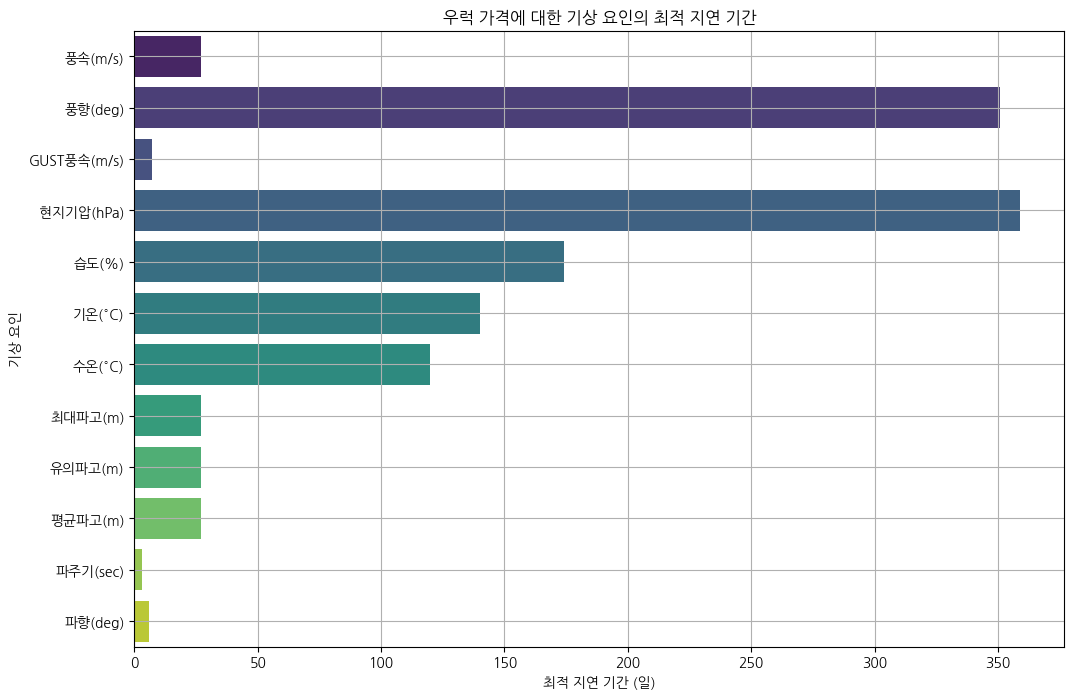

In [16]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 특정 어종 선택 (예: 우럭)
fish_type = '우럭'
fish_prices = price_data[price_data['item'] == fish_type][['날짜', 'avgPrice']]

# 시차 적용 및 신뢰도 분석 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=360, bootstrap_samples=100):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        best_p_value = 1.0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            if merged_df.empty:
                continue

            # 상관관계 분석 및 p-value 계산
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, p_value = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr and p_value < 0.05:  # 유의한 경우만 선택
                best_corr = corr
                best_lag = lag
                best_p_value = p_value

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_prices = fish_prices.iloc[sampled_indices]
            shifted_sample = sampled_prices.copy()
            shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            'p-value': best_p_value,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

# 분석 수행
feature_columns = daily_avg.columns.drop('날짜')
optimal_lags_with_confidence = find_optimal_lags_with_confidence(fish_prices, daily_avg, feature_columns)

# 최적 지연 기간 결과 출력 (p-value 포함)
print("\n각 기상 요인의 최적 지연 기간 및 신뢰구간:")
for feature, result in optimal_lags_with_confidence.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, p-value: {result['p-value']:.4f}, "
          f"신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}")

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
            y=list(optimal_lags_with_confidence.keys()),
            palette='viridis')
plt.title(f'{fish_type} 가격에 대한 기상 요인의 최적 지연 기간')
plt.xlabel('최적 지연 기간 (일)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()


각 기상 요인의 최적 지연 기간 및 신뢰구간:
풍속(m/s): 303일, 상관계수: 0.1023, 신뢰구간: 0.0755 ~ 0.1398
풍향(deg): 296일, 상관계수: 0.0463, 신뢰구간: 0.0120 ~ 0.0733
GUST풍속(m/s): 303일, 상관계수: 0.0910, 신뢰구간: 0.0637 ~ 0.1278
현지기압(hPa): 324일, 상관계수: 0.1507, 신뢰구간: 0.1207 ~ 0.1822
습도(%): 129일, 상관계수: 0.1481, 신뢰구간: 0.1121 ~ 0.1764
기온(°C): 112일, 상관계수: 0.1831, 신뢰구간: 0.1559 ~ 0.2087
수온(°C): 89일, 상관계수: 0.2245, 신뢰구간: 0.1872 ~ 0.2626
최대파고(m): 315일, 상관계수: 0.0327, 신뢰구간: 0.0047 ~ 0.0621
유의파고(m): 315일, 상관계수: 0.0494, 신뢰구간: 0.0149 ~ 0.0912
평균파고(m): 315일, 상관계수: 0.1032, 신뢰구간: 0.0672 ~ 0.1348
파주기(sec): 359일, 상관계수: -0.0903, 신뢰구간: -0.1274 ~ -0.0556
파향(deg): 305일, 상관계수: -0.1964, 신뢰구간: -0.2277 ~ -0.1618


C:\Users\user\AppData\Local\Temp\ipykernel_30016\1542921247.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


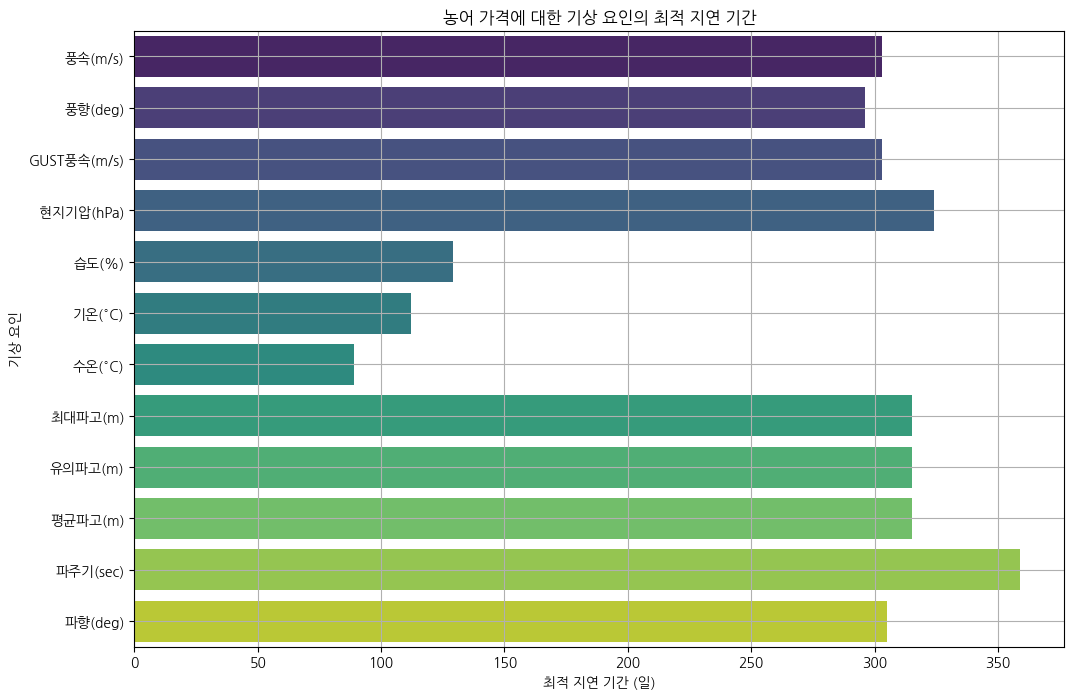

In [39]:
# 수산물 가격 데이터 로드
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 특정 어종 선택 (예: 우럭)
fish_type = '농어'
fish_prices = price_data[price_data['item'] == fish_type][['날짜', 'avgPrice']]

# 시차 적용 및 신뢰도 분석 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=360, bootstrap_samples=100):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            if merged_df.empty:
                continue

            # 상관관계 분석
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_prices = fish_prices.iloc[sampled_indices]
            shifted_sample = sampled_prices.copy()
            shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

# 분석 수행 (1일부터 360일까지 모든 기간 탐색 및 신뢰도 계산)
feature_columns = daily_avg.columns.drop('날짜')
optimal_lags_with_confidence = find_optimal_lags_with_confidence(fish_prices, daily_avg, feature_columns)

# 최적 지연 기간 결과 출력
print("\n각 기상 요인의 최적 지연 기간 및 신뢰구간:")
for feature, result in optimal_lags_with_confidence.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}")

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
            y=list(optimal_lags_with_confidence.keys()),
            palette='viridis')
plt.title(f'{fish_type} 가격에 대한 기상 요인의 최적 지연 기간')
plt.xlabel('최적 지연 기간 (일)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()


각 기상 요인의 최적 지연 기간 및 신뢰구간 (마라도 지점):
풍속(m/s): 303일, 상관계수: 0.1325, 신뢰구간: 0.0901 ~ 0.1610
풍향(deg): 1일, 상관계수: 0.0377, 신뢰구간: -0.0325 ~ 0.0377
GUST풍속(m/s): 303일, 상관계수: 0.1214, 신뢰구간: 0.0817 ~ 0.1418
현지기압(hPa): 332일, 상관계수: 0.1810, 신뢰구간: 0.1166 ~ 0.1739
습도(%): 150일, 상관계수: 0.1072, 신뢰구간: -0.1682 ~ -0.0988
기온(°C): 113일, 상관계수: 0.1993, 신뢰구간: -0.0420 ~ 0.0135
수온(°C): 78일, 상관계수: 0.2996, 신뢰구간: 0.0822 ~ 0.1480
최대파고(m): 2일, 상관계수: 0.0913, 신뢰구간: 0.0413 ~ 0.1145
유의파고(m): 2일, 상관계수: 0.0991, 신뢰구간: 0.0352 ~ 0.1091
평균파고(m): 4일, 상관계수: 0.1416, 신뢰구간: 0.0838 ~ 0.1553
파주기(sec): 86일, 상관계수: 0.0264, 신뢰구간: -0.0759 ~ -0.0015
파향(deg): 337일, 상관계수: 0.1507, 신뢰구간: 0.1034 ~ 0.1637


C:\Users\user\AppData\Local\Temp\ipykernel_30016\399340483.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


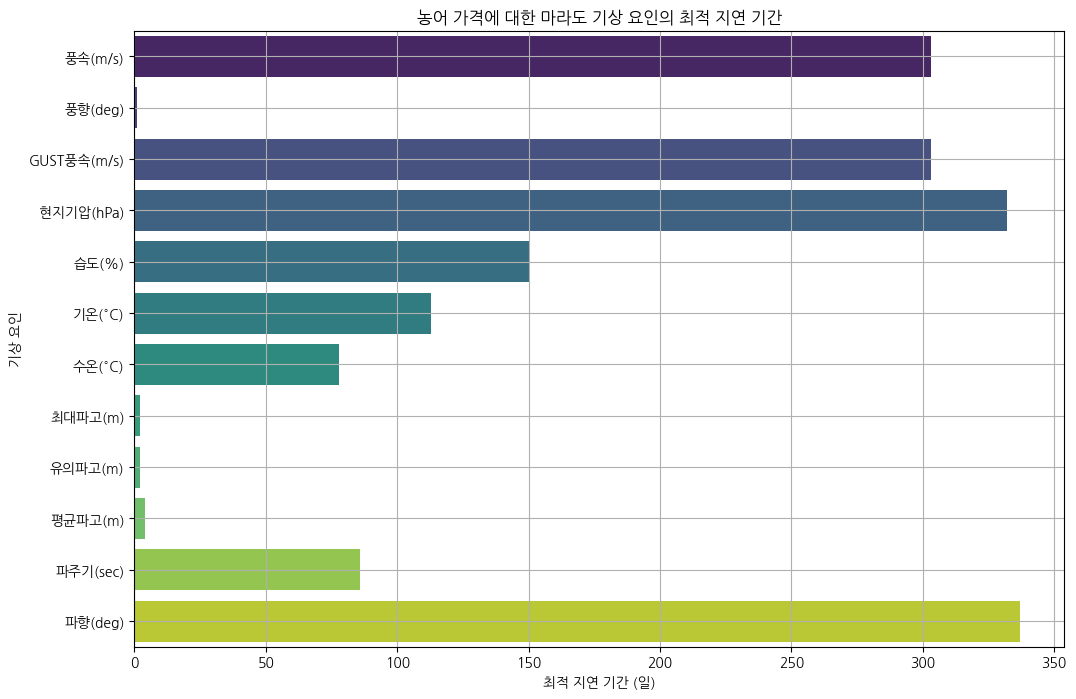

In [73]:
price_data = pd.read_csv('../data/processed/item_price_lag_filled.csv')
price_data['priceDate'] = pd.to_datetime(price_data['priceDate'])
price_data['날짜'] = price_data['priceDate'].dt.date
price_data = price_data.groupby(['날짜', 'item'])['avgPrice'].mean().reset_index()

# 여러 개의 기상 데이터 파일 불러오기
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')

df_list = []
for file in file_list:
    df = pd.read_csv(file, encoding='euc-kr')
    df['일시'] = pd.to_datetime(df['일시'])
    df['날짜'] = df['일시'].dt.date
    df_list.append(df)

# 모든 데이터를 병합
forecast_df = pd.concat(df_list, ignore_index=True)

# 마라도(지점 코드 22107)만 필터링
forecast_df = forecast_df[forecast_df['지점'] == 22107]
forecast_df = forecast_df.drop(columns=['지점'], errors='ignore')
daily_avg = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 특정 어종 선택 (예: 농어)
fish_type = '농어'
fish_prices = price_data[price_data['item'] == fish_type][['날짜', 'avgPrice']]

# 시차 적용 및 신뢰도 분석 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=360, bootstrap_samples=100):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')

            # 결측값 처리
            if merged_df.isnull().sum().sum() > 0:
                # print(f"{feature} - {lag}일 지연: 결측값 존재 {merged_df.isnull().sum().sum()}건, 제거 후 진행")
                merged_df.dropna(inplace=True)

            if merged_df.empty:
                # print(f"{feature} - {lag}일 지연: 병합된 데이터 없음")
                continue

            # 상관계수 계산
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            # print(f"{feature} - {lag}일 지연: 상관계수 {corr:.4f}")

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(merged_df), len(merged_df), replace=True)
            sampled_weather = merged_df[[feature]].iloc[sampled_indices]
            sampled_price = merged_df[['avgPrice']].iloc[sampled_indices]

            if len(sampled_weather.dropna()) < 10:  # 최소 샘플 수 검증
                continue

            weather_scaled = scaler.fit_transform(sampled_weather)
            price_scaled = scaler.fit_transform(sampled_price)
            boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
            bootstrap_lags.append(boot_corr)

        if bootstrap_lags:
            conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])
        else:
            conf_low, conf_high = np.nan, np.nan

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

# 분석 수행 (1일부터 360일까지 모든 기간 탐색 및 신뢰도 계산)
feature_columns = daily_avg.columns.drop('날짜')
optimal_lags_with_confidence = find_optimal_lags_with_confidence(fish_prices, daily_avg, feature_columns)

# 최적 지연 기간 결과 출력
print("\n각 기상 요인의 최적 지연 기간 및 신뢰구간 (마라도 지점):")
for feature, result in optimal_lags_with_confidence.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}")

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
            y=list(optimal_lags_with_confidence.keys()),
            palette='viridis')
plt.title(f'{fish_type} 가격에 대한 마라도 기상 요인의 최적 지연 기간')
plt.xlabel('최적 지연 기간 (일)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()